FIGURE S01 - FTIR Processing Pipeline Visualization

Loaded reference wavenumber axis: 225 points
Range: 1525.8 to 1749.8 cm⁻¹

Processing file: GVGn1_WT_50mgmL_phos_150mM_pH1_basecorr.CSV
Sample: WT
  Loaded 490 data points
  After filtering: 233 points
  Final spectrum: 225 points


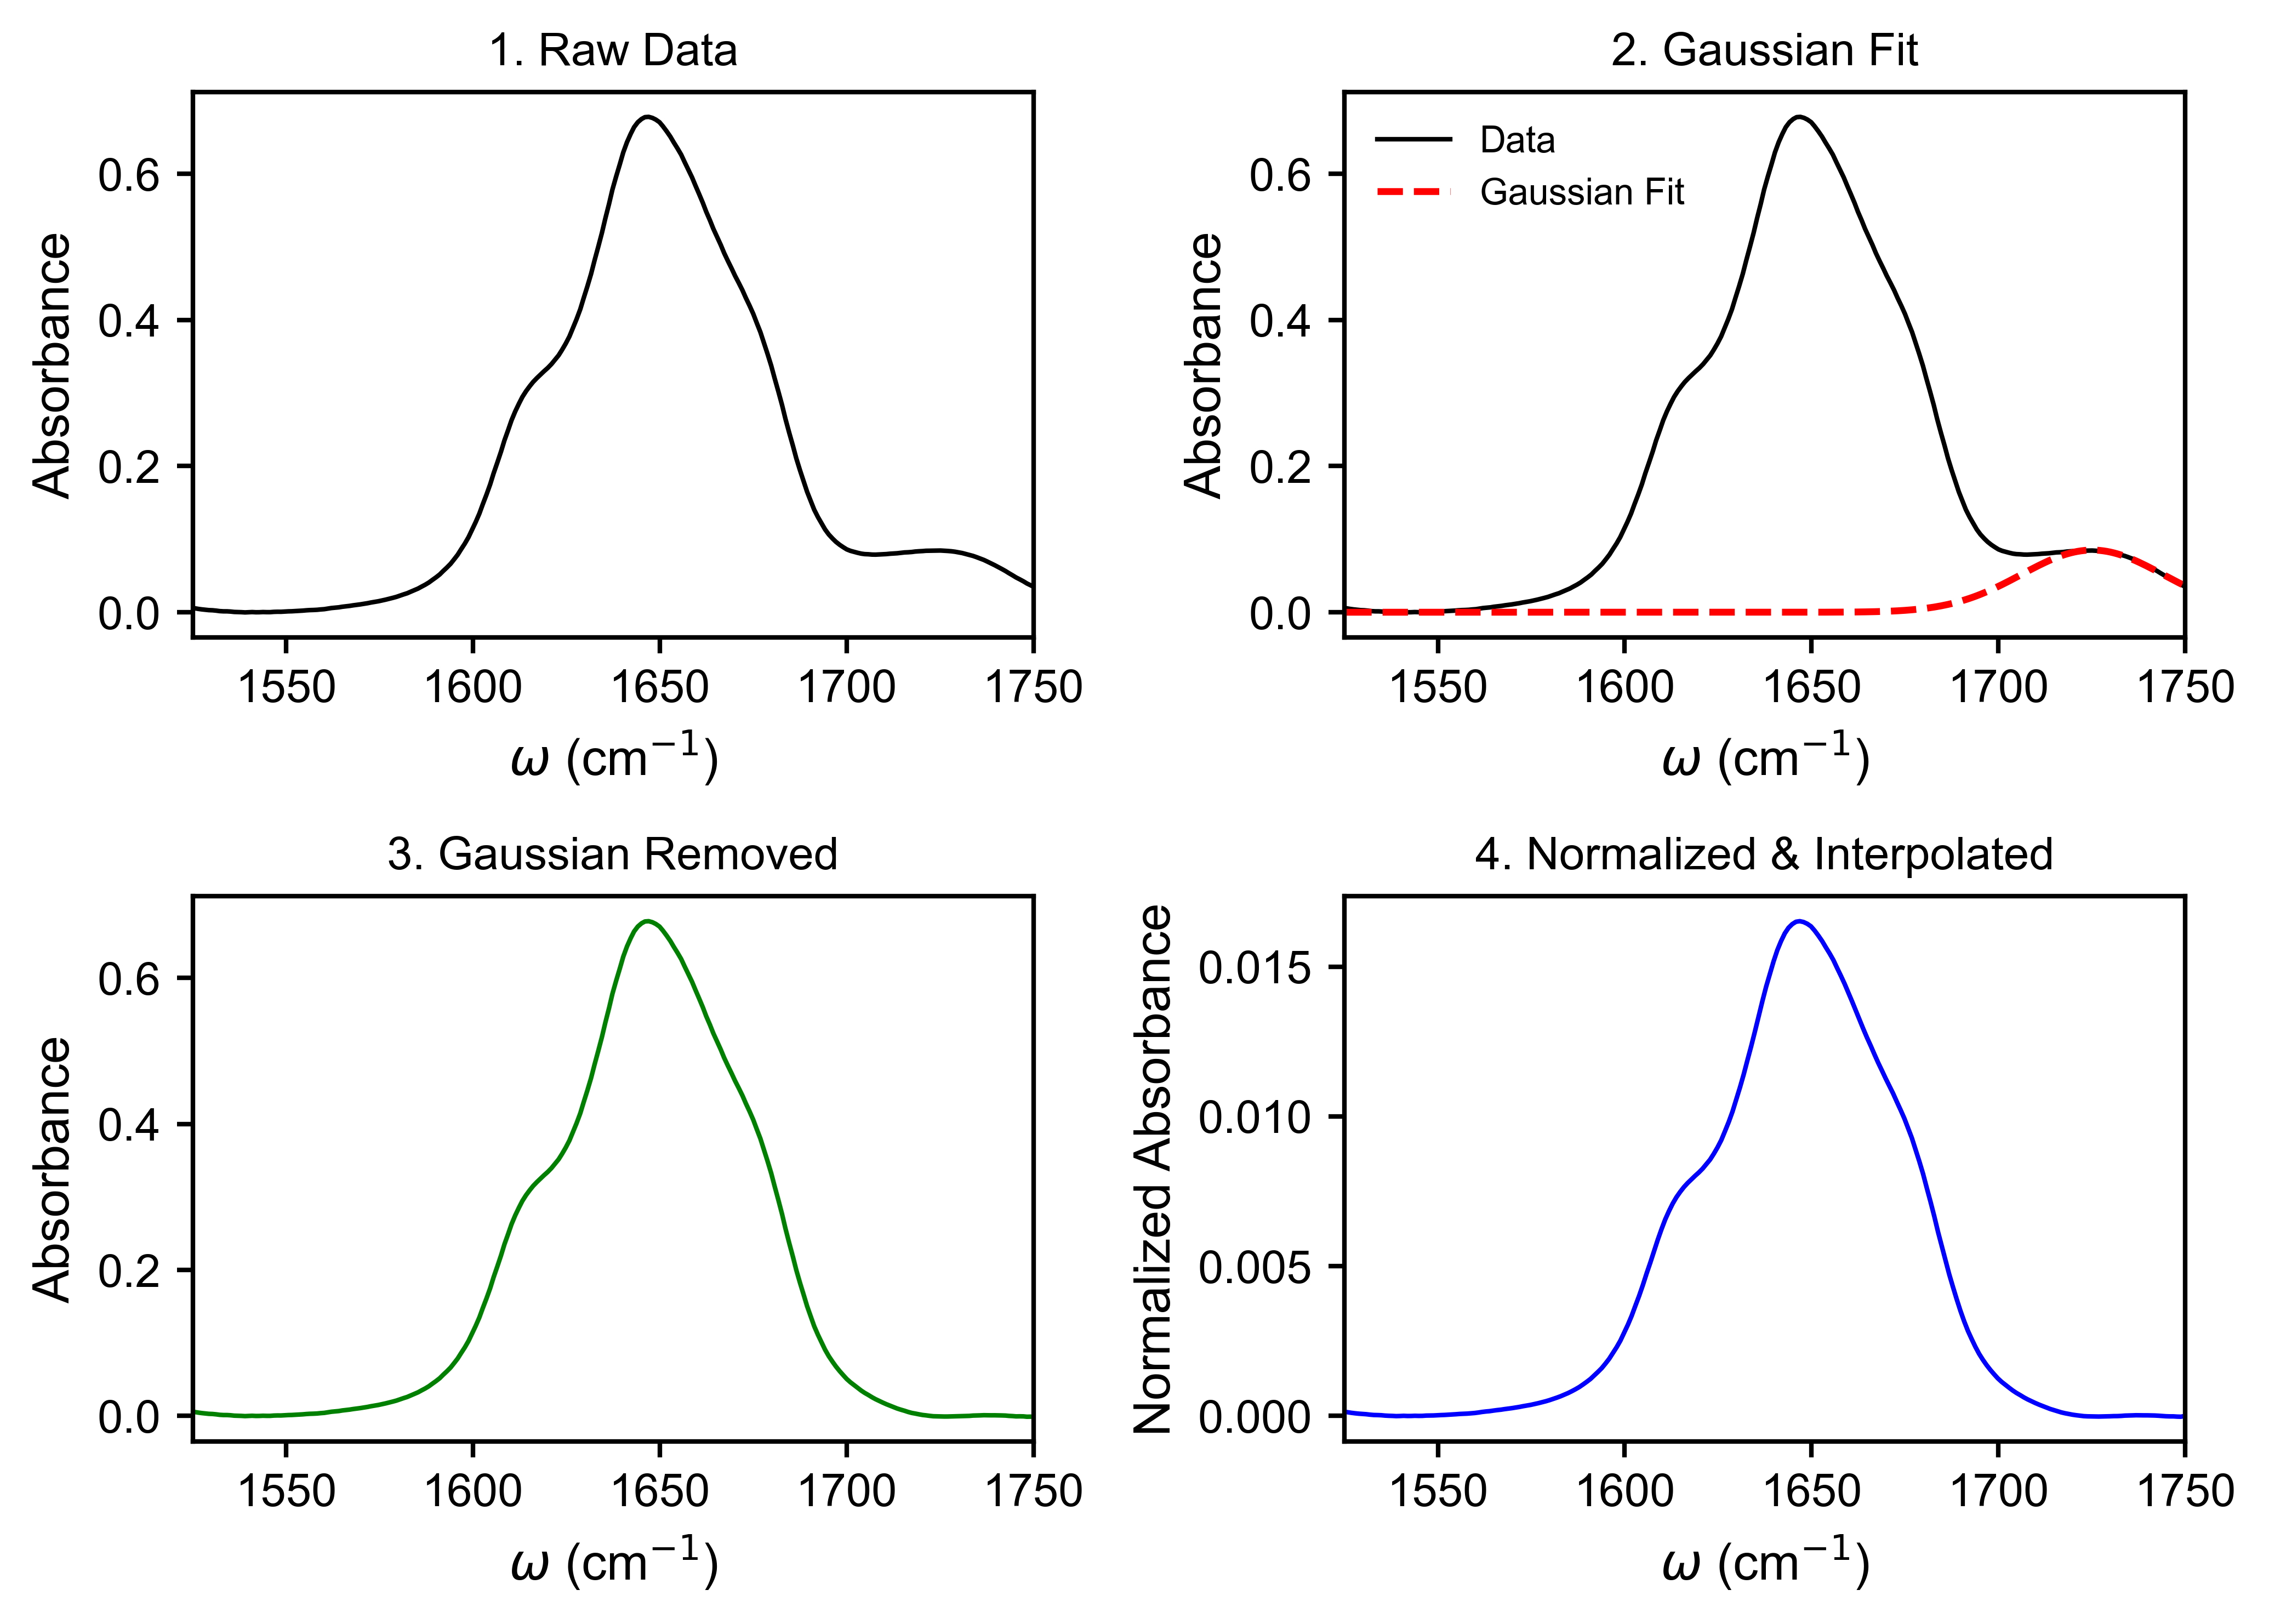

In [1]:
### EXAMPLE OF DATA PROCESSING FOR UL SAMPLE ###
### MATCHES data/exp_data/process_FTIR_data ###
### 2 Aug 2025 ###

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.integrate import trapz

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------

# File paths - where to find data
BASE_DIR = Path('../data')
FTIR_DIR = BASE_DIR / 'exp_data' / 'raw_FTIRs'
WAVENUMBERS_FILE = BASE_DIR / 'waxis.txt'  # Reference wavenumber axis

# Which sample to process for the figure
SAMPLE_PATTERN = 'WT'  # Will find file containing 'WT' in the name

# Analysis parameters (matching main processing script)
PEAK_SEARCH_RANGE = (1700, 1750)  # Where to look for COOH peak (in cm⁻¹)
REFINED_RANGE = (1525, 1750)      # Final wavenumber range we want
INITIAL_SIGMA = 10                # Initial guess for Gaussian width

# Figure specifications for publication
FIGURE_SIZE = (7, 5.25)  # Figure size in inches
DPI = 300                # Resolution for saving

# -----------------------------------------------------------------------------
# DATA LOADING FUNCTIONS
# -----------------------------------------------------------------------------

def load_wavenumber_axis():
    """
    Load and filter wavenumber axis to simulated frequency axis
    Returns:
        wavenumbers: 1D array of wavenumbers in refined range, Shape: (225,)
    """
    wavenumbers = np.loadtxt(WAVENUMBERS_FILE)  # Shape: (full_length,)
    mask = (wavenumbers >= REFINED_RANGE[0]) & (wavenumbers <= REFINED_RANGE[1])
    return wavenumbers[mask]  # Shape: (n_refined,)

def load_ftir_data(csv_path):
    """
    Loads experimental FTIR data from a CSV file with two columns: wavenumber and absorbance.
    Args:
        csv_path: Path to the CSV file
    Returns:
        wavenumbers: 1D array of wavenumbers (cm⁻¹)
        absorbances: 1D array of absorbance values
    """
    df = pd.read_csv(csv_path)
    wavenumbers = df.iloc[:, 0].values  # First column: wavenumbers
    absorbances = df.iloc[:, 1].values  # Second column: absorbances
    return wavenumbers, absorbances

def find_sample_file(sample_pattern):
    """
    Find CSV file containing the specified sample pattern in its name.
    Args:
        sample_pattern: String pattern to search for in filenames
    Returns:
        filepath: Path object for the matching file
    Raises:
        FileNotFoundError: If no matching file is found
    """
    # Look for both .csv and .CSV extensions
    for filepath in FTIR_DIR.glob('*.CSV'):
        if sample_pattern in filepath.name:
            return filepath
    for filepath in FTIR_DIR.glob('*.csv'):
        if sample_pattern in filepath.name:
            return filepath
            
    raise FileNotFoundError(f"No file containing '{sample_pattern}' found in {FTIR_DIR}")

# --------------------------------------------------------------------------------------
# PROCESSING FUNCTIONS (matches the main script for data/exp_data/process_FTIR_data.py)
# --------------------------------------------------------------------------------------

def fit_and_subtract_gaussian(x, y):
    """
    Finds the COOH peak in the spectrum and removes it by fitting a Gaussian. 
    The COOH peak typically appears around 1720 cm⁻¹ and is not included
    in the amide I Hamiltonian, so we remove it.
    
    Args:
        x: 1D array of wavenumbers, shape: (n_points,)
        y: 1D array of absorbances, shape: (n_points,)
    Returns:
        gauss_fit: The fitted Gaussian curve, shape: (n_points,)
        y_corrected: Original data with Gaussian subtracted, shape: (n_points,)
    """
    # Extract just the region where we expect the COOH peak
    mask = (x >= PEAK_SEARCH_RANGE[0]) & (x <= PEAK_SEARCH_RANGE[1])
    x_peak_region = x[mask]  
    y_peak_region = y[mask]  
    
    if y_peak_region.size > 0:
        # Find all peaks in this region
        peaks, _ = find_peaks(y_peak_region)  # peaks shape: (n_peaks,)
        
        if peaks.size > 0:
            # Find the highest peak (this should be the COOH peak)
            highest_peak_idx = peaks[np.argmax(y_peak_region[peaks])]
            peak_position = x_peak_region[highest_peak_idx]
            peak_amplitude = y_peak_region[highest_peak_idx]
            
            # Define Gaussian function centered at the peak position
            def gaussian(x_, A, sigma):
                return A * np.exp(-(x_ - peak_position)**2 / (2 * sigma**2))
            
            try:
                # Fit Gaussian only to the right side of the peak (blue edge)
                # This helps avoid fitting to overlapping peaks on the red side
                fit_mask = x >= peak_position
                x_fit = x[fit_mask]  # Shape: (n_fit_points,)
                y_fit = y[fit_mask]  # Shape: (n_fit_points,)
                
                # Perform the fit
                params, _ = curve_fit(gaussian, x_fit, y_fit, 
                                    p0=[peak_amplitude, INITIAL_SIGMA])
                # Generate the full Gaussian curve
                gauss_fit = gaussian(x, *params)  # Shape: (n_points,)
                # Subtract Gaussian from original data
                y_corrected = y - gauss_fit  # Shape: (n_points,)
                
                return gauss_fit, y_corrected
                
            except RuntimeError:
                # If fitting fails, return original data unchanged
                print("  WARNING: Gaussian fitting failed, skipping COOH removal")
                pass
    
    # If no peak found or fitting failed, return zeros for Gaussian and original data
    return np.zeros_like(y), y

def normalize_spectrum(x_data, y_data, waxis_refined):
    """
    Interpolates spectrum to the common wavenumber axis and normalizes by area.    
    Args:
        x_data: Original wavenumbers, Shape: (n_original,)
        y_data: Original absorbances, Shape: (n_original,)
        waxis_refined: Target wavenumber axis, Shape: (225,)
        
    Returns:
        y_normalized: Interpolated and normalized spectrum, Shape: (225,)
    """
    # Interpolate data to the common wavenumber axis
    y_interp = np.interp(waxis_refined, x_data, y_data, 
                        left=0, right=0)  # Shape: (225,)
    # Calculate area under the curve using trapezoidal integration
    area = trapz(y_interp, waxis_refined)  
    y_normalized = y_interp / area
        
    return y_normalized

def process_ftir_spectrum(csv_path, target_wavenumbers): # returns a dictionary
    """
    Complete FTIR processing pipeline for a single file.
    Matches the processing in the main script.
    
    Args:
        csv_path: Path to the CSV file
        target_wavenumbers: Reference wavenumber axis, Shape: (n_target,)
        
    Returns:
        Dictionary containing all intermediate and final results
    """
    # Load raw data
    wavenumbers, intensities = load_ftir_data(csv_path)
    print(f"  Loaded {len(wavenumbers)} data points")
    
    # Filter to refined range
    mask = (wavenumbers >= REFINED_RANGE[0]) & (wavenumbers <= REFINED_RANGE[1])
    x_filtered = wavenumbers[mask]  # Shape: (n_filtered,)
    y_filtered = intensities[mask]   # Shape: (n_filtered,)
    print(f"  After filtering: {len(x_filtered)} points")
    
    # Fit and remove COOH peak
    gaussian_fit, y_corrected = fit_and_subtract_gaussian(x_filtered, y_filtered)
    
    # Normalize and interpolate
    y_normalized = normalize_spectrum(x_filtered, y_corrected, target_wavenumbers)
    print(f"  Final spectrum: {len(target_wavenumbers)} points")
    
    return {
        'x_filtered': x_filtered,
        'y_filtered': y_filtered,
        'gaussian_fit': gaussian_fit,
        'y_corrected': y_corrected,
        'target_wavenumbers': target_wavenumbers,
        'y_normalized': y_normalized
    }

# -----------------------------------------------------------------------------
# PLOTTING FUNCTIONS
# -----------------------------------------------------------------------------

def set_plot_style():
    """Set consistent plot style for ACS publication figures."""
    plt.rcParams.update({
        # Font settings - Arial (PC) or Helvetica (Mac) as per ACS
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica'],
        'font.size': 10,  # Will be readable at 5pt when reduced to column width
        
        # Line widths - minimum 1 pt as per ACS
        'lines.linewidth': 1.0,
        'axes.linewidth': 1.0,
        'xtick.major.width': 1.0,
        'ytick.major.width': 1.0,
        'xtick.minor.width': 1.0,
        'ytick.minor.width': 1.0,
        'patch.linewidth': 1.0,
        'grid.linewidth': 1.0,
        
        # Font sizes - accounting for reduction
        'axes.labelsize': 11,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        
        # DPI settings
        'figure.dpi': 600
    })

def plot_processing_pipeline(results, sample_name): # uses the dictionary from above
    """
    Create four-panel figure showing FTIR processing steps.
    This matches the diagnostic plots in the main script but with
    publication-quality formatting.
    
    Args:
        results: Dictionary from process_ftir_spectrum
        sample_name: Name of the sample for the title
    """
    fig, axes = plt.subplots(2, 2, figsize=FIGURE_SIZE)
    
    # Panel 1: Raw filtered data
    axes[0, 0].plot(results['x_filtered'], results['y_filtered'], 'k-', linewidth=1.0)
    axes[0, 0].set_title('1. Raw Data', fontsize=10)
    axes[0, 0].set_xlabel(r'$\omega$ (cm$^{-1}$)')
    axes[0, 0].set_ylabel('Absorbance')
    axes[0, 0].set_xlim(REFINED_RANGE)
    
    # Panel 2: Gaussian fit overlay
    axes[0, 1].plot(results['x_filtered'], results['y_filtered'], 'k-', 
                   linewidth=1.0, label='Data')
    axes[0, 1].plot(results['x_filtered'], results['gaussian_fit'], 'r--', 
                   linewidth=1.5, label='Gaussian Fit')
    axes[0, 1].set_title('2. Gaussian Fit', fontsize=10)
    axes[0, 1].set_xlabel(r'$\omega$ (cm$^{-1}$)')
    axes[0, 1].set_ylabel('Absorbance')
    axes[0, 1].set_xlim(REFINED_RANGE)
    axes[0, 1].legend(frameon=False, fontsize=8)
    
    # Panel 3: After Gaussian removal
    axes[1, 0].plot(results['x_filtered'], results['y_corrected'], 'g-', linewidth=1.0)
    axes[1, 0].set_title('3. Gaussian Removed', fontsize=10)
    axes[1, 0].set_xlabel(r'$\omega$ (cm$^{-1}$)')
    axes[1, 0].set_ylabel('Absorbance')
    axes[1, 0].set_xlim(REFINED_RANGE)
    
    # Panel 4: Final normalized spectrum
    axes[1, 1].plot(results['target_wavenumbers'], results['y_normalized'], 'b-', 
                   linewidth=1.0)
    axes[1, 1].set_title('4. Normalized & Interpolated', fontsize=10)
    axes[1, 1].set_xlabel(r'$\omega$ (cm$^{-1}$)')
    axes[1, 1].set_ylabel('Normalized Absorbance')
    axes[1, 1].set_xlim(REFINED_RANGE)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig

# -----------------------------------------------------------------------------
# MAIN EXECUTION
# -----------------------------------------------------------------------------

def main():
    """
    Main function to create Figure S01 showing FTIR processing pipeline.
    """
    print("="*60)
    print("FIGURE S01 - FTIR Processing Pipeline Visualization")
    print("="*60)
    
    # Set plot style
    set_plot_style()
    
    try:
        # Load reference wavenumber axis
        target_wavenumbers = load_wavenumber_axis()
        print(f"\nLoaded reference wavenumber axis: {len(target_wavenumbers)} points")
        print(f"Range: {target_wavenumbers[0]:.1f} to {target_wavenumbers[-1]:.1f} cm⁻¹")
        
        # Find sample file
        sample_file = find_sample_file(SAMPLE_PATTERN)
        sample_name = sample_file.stem.split('_')[1].replace('dag', '+')
        print(f"\nProcessing file: {sample_file.name}")
        print(f"Sample: {sample_name}")
        
        # Process spectrum
        results = process_ftir_spectrum(sample_file, target_wavenumbers)
        
        # Create visualization
        fig = plot_processing_pipeline(results, sample_name)
        plt.show()
        
    except FileNotFoundError as e:
        print(f"\nError: {e}")
        print("Please check that the specified sample pattern exists in the data directory.")
    except Exception as e:
        print(f"\nUnexpected error during processing: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()